In [190]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torchvision import utils as vutils
from mpl_toolkits.axes_grid1 import ImageGrid

# Create a transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 250
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set input variables
x_dim_size = 784
hidden_dim_size = 512
hidden_dim2_size = 256
latent_size = 2

lr = 1e-3
epochs = 100
batch_size = 250

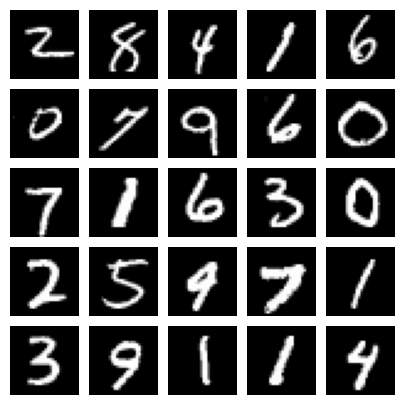

In [191]:
# Not necessery part but good for visualization
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [192]:
# Create the class for the encoder
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [193]:
# Create the class for the decoder
class Decoder(nn.Module):
    
    def __init__(self, output_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim2)
        self.linear1 = nn.Linear(hidden_dim2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [194]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [195]:
encoder = Encoder(input_dim=x_dim_size, hidden_dim=hidden_dim_size, hidden_dim2=hidden_dim2_size, latent_dim=latent_size)
decoder = Decoder(latent_dim=latent_size, hidden_dim = hidden_dim_size, hidden_dim2=hidden_dim2_size, output_dim = x_dim_size)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [196]:
# Define reconstruction loss function and optimizer
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

Start training VAE...
	Epoch 1 complete! 	Average Loss:  190.79968632322175


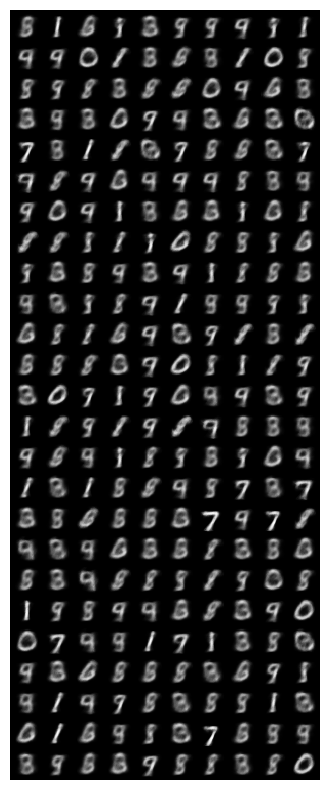

	Epoch 2 complete! 	Average Loss:  166.31579720188284
	Epoch 3 complete! 	Average Loss:  161.96323156380754
	Epoch 4 complete! 	Average Loss:  158.53910506014645
	Epoch 5 complete! 	Average Loss:  156.28295724372384
	Epoch 6 complete! 	Average Loss:  154.43590932269873
	Epoch 7 complete! 	Average Loss:  153.0447022751046
	Epoch 8 complete! 	Average Loss:  151.89702889644352
	Epoch 9 complete! 	Average Loss:  151.05669828713388
	Epoch 10 complete! 	Average Loss:  150.13423731694562
	Epoch 11 complete! 	Average Loss:  149.43194410303346
	Epoch 12 complete! 	Average Loss:  148.6764666579498
	Epoch 13 complete! 	Average Loss:  148.07686074790794
	Epoch 14 complete! 	Average Loss:  147.6691142128661
	Epoch 15 complete! 	Average Loss:  147.22937761506276
	Epoch 16 complete! 	Average Loss:  146.7124303085774
	Epoch 17 complete! 	Average Loss:  146.36347411087866
	Epoch 18 complete! 	Average Loss:  146.08142350941424
	Epoch 19 complete! 	Average Loss:  145.61734505753137
	Epoch 20 complete! 	A

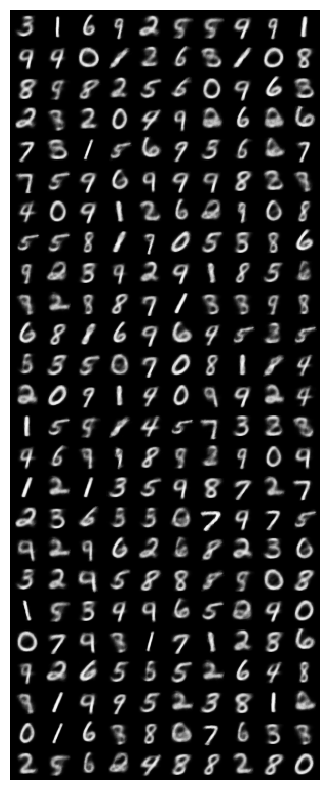

	Epoch 51 complete! 	Average Loss:  140.25534558054395
	Epoch 52 complete! 	Average Loss:  140.0965568122385
	Epoch 53 complete! 	Average Loss:  139.8585734832636
	Epoch 54 complete! 	Average Loss:  139.82487813807532
	Epoch 55 complete! 	Average Loss:  139.6688667625523
	Epoch 56 complete! 	Average Loss:  139.6833500915272
	Epoch 57 complete! 	Average Loss:  139.6991066291841
	Epoch 58 complete! 	Average Loss:  139.51352546417365
	Epoch 59 complete! 	Average Loss:  139.31228520528242
	Epoch 60 complete! 	Average Loss:  139.3217143043933
	Epoch 61 complete! 	Average Loss:  139.35441138206068
	Epoch 62 complete! 	Average Loss:  139.33160669456066
	Epoch 63 complete! 	Average Loss:  139.07462846495815
	Epoch 64 complete! 	Average Loss:  138.82180746600417
	Epoch 65 complete! 	Average Loss:  138.85828347280335
	Epoch 66 complete! 	Average Loss:  138.89619475679916
	Epoch 67 complete! 	Average Loss:  138.9250593619247
	Epoch 68 complete! 	Average Loss:  138.76629573091003
	Epoch 69 complet

In [197]:
def visualize_generated_data(generated_data, digit_size=28):
    # Reshape if necessary and make grid
    data = generated_data.view(-1, 1, digit_size, digit_size)  # Assuming MNIST-like images
    grid = vutils.make_grid(data.cpu(), nrow=10, normalize=True).permute(1, 2, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, interpolation='nearest')
    plt.axis('off')
    plt.show()

# Train the VAE
print("Start training VAE...")
model.train()

noise_batch = torch.randn(batch_size, latent_size).to(DEVICE)

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim_size)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        generated_data = model.Decoder(noise_batch)
    if epoch==1 or epoch==50 or epoch==100:
        visualize_generated_data(generated_data)

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Done!!")

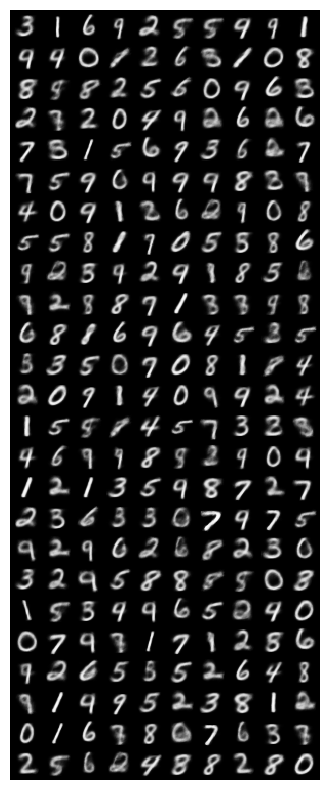

In [206]:
with torch.no_grad():
        model.eval()
        generated_data = model.Decoder(noise_batch)
visualize_generated_data(generated_data)

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]


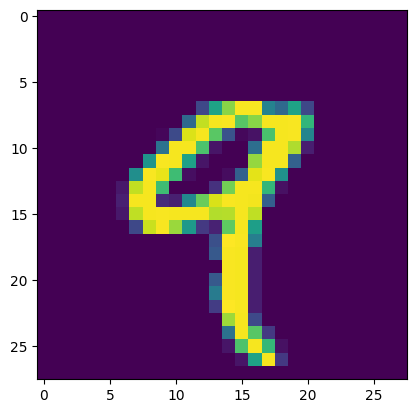

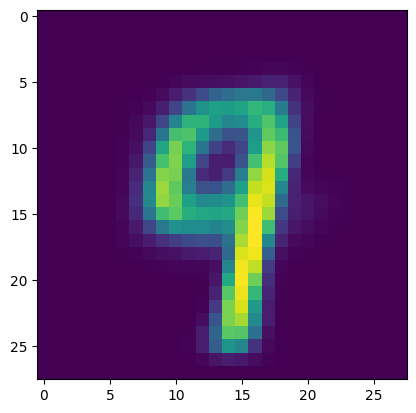

In [202]:
torch.save(model.state_dict(), 'model_weights.pth')

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim_size)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

show_image(x, idx=4)
show_image(x_hat, idx=4)

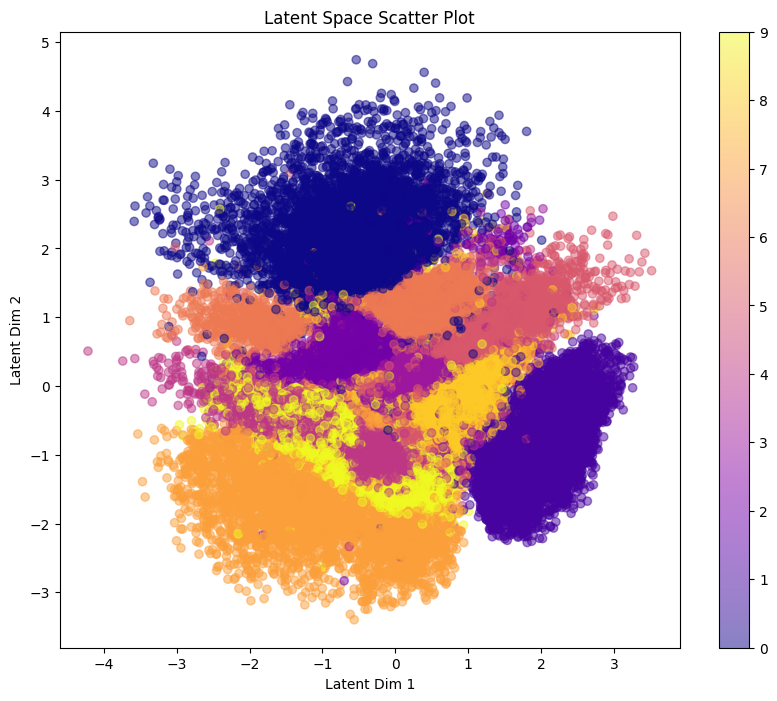

In [199]:
latent_variables = []
labels = []

with torch.no_grad():
    for x,y in test_loader:
        x = x.view(-1, x_dim_size).to(DEVICE)
        mean, _ = model.Encoder(x)
        latent_variables.append(mean.cpu().numpy())
        labels.append(y.cpu().numpy())

# Concatenate all collected batches
latent_variables = np.concatenate(latent_variables, axis=0)
labels = np.concatenate(labels, axis=0)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=labels, cmap='plasma', alpha=0.5)
plt.colorbar(scatter)  # Show color scale
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Scatter Plot')
plt.show()

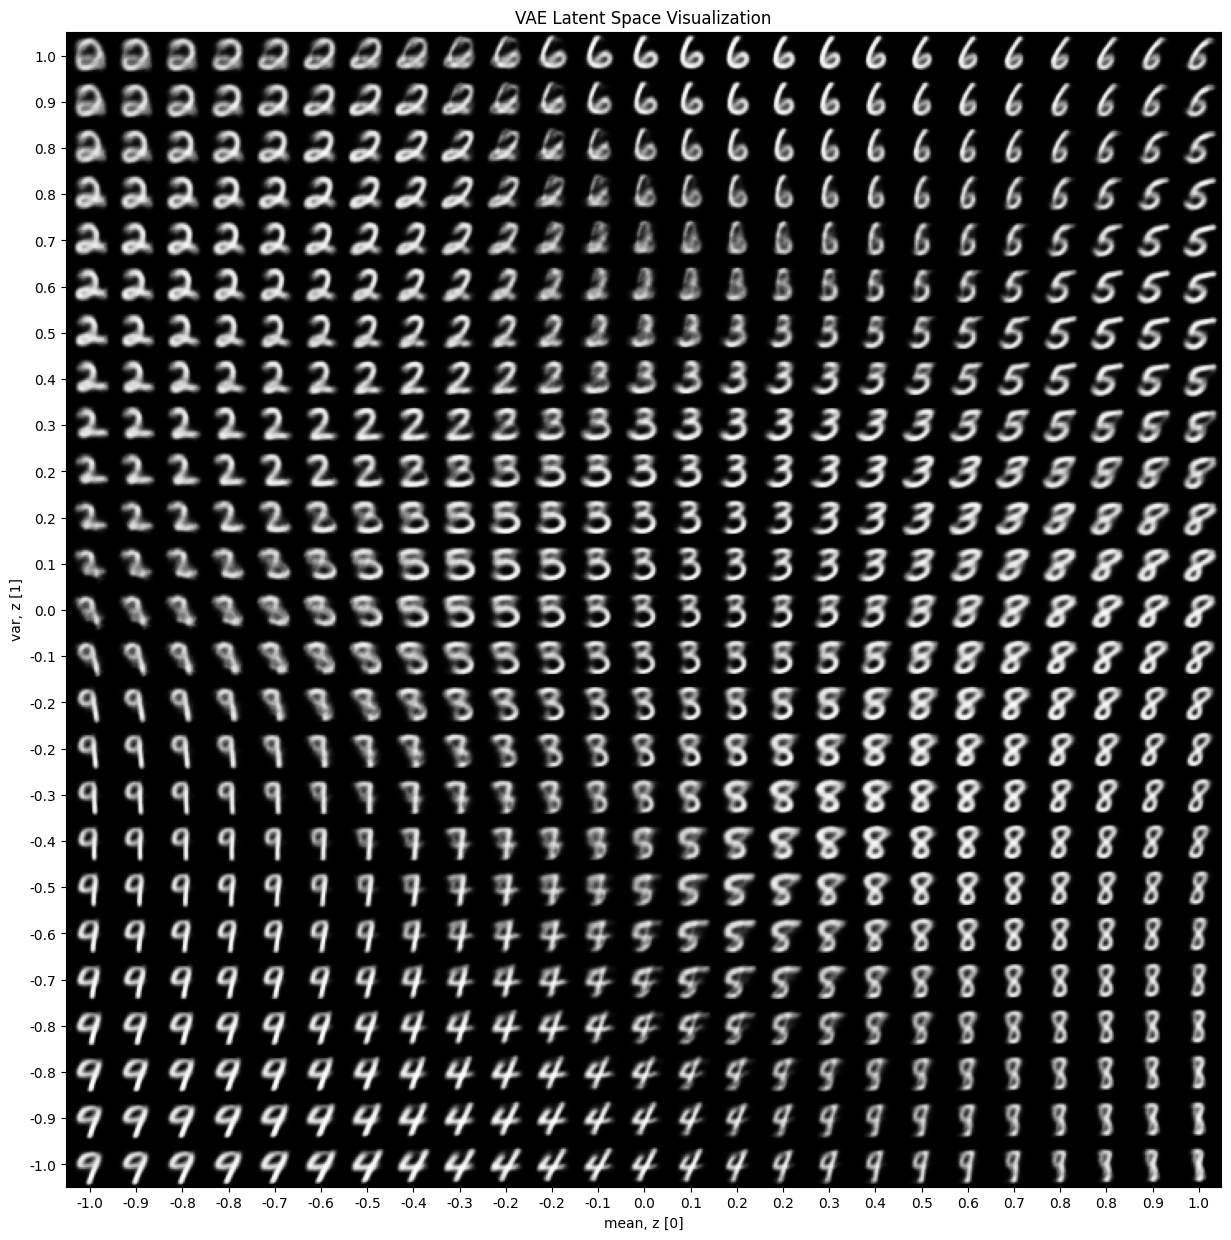

In [200]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.Decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale=1.0)

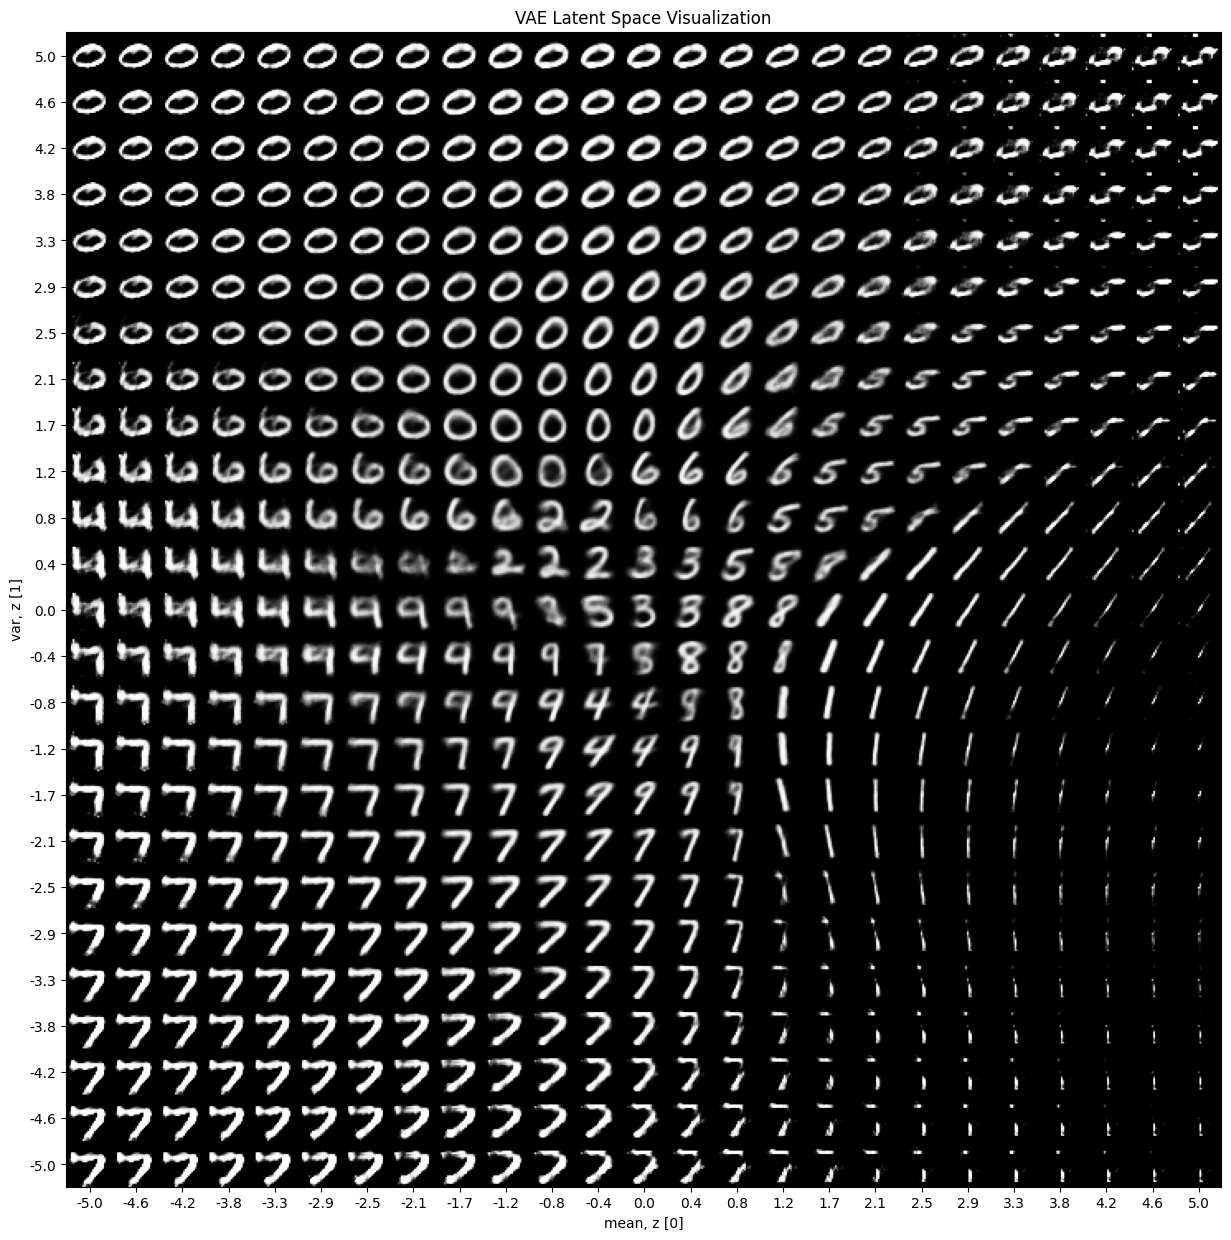

In [201]:
plot_latent_space(model, scale=5.0)